### Multi Head Attention

In [91]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
import random

random.seed(8)

In [93]:
sequence_length = 4
batch_size = 1
input_dim = 512
d_model = 512

# Mock positioning encoding of input sequence length.
x = torch.randn(
    (batch_size, sequence_length, input_dim)
)

In [94]:
x.size()

torch.Size([1, 4, 512])

In [96]:
# This is to create a concatenated vector of Query, Key and Value (QKV)
qkv_layer = nn.Linear(input_dim, 3 * d_model)

In [97]:
qkv = qkv_layer(x)

In [103]:
qkv.shape

torch.Size([1, 4, 1536])

Text(0.5, 1.0, 'qkv distribution')

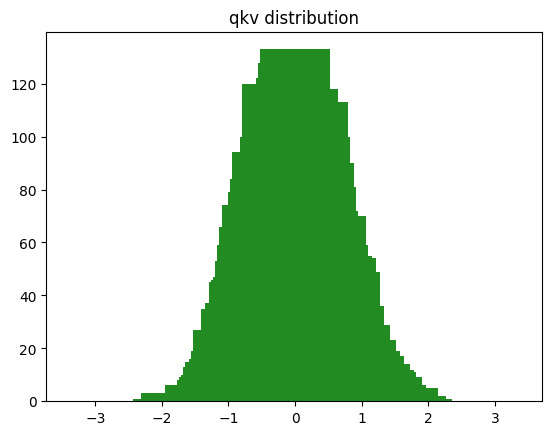

In [104]:
import matplotlib.pyplot as plt
y_val = torch.histc(qkv, bins=200, min=-3, max=3)
x_val = np.arange(-1, 1, 0.01) * 3
plt.bar(x_val, y_val, align='center', color=['forestgreen'])
plt.title('qkv distribution')

In [108]:
# Dividing the tensor in equal parts for each multi-head attention unit.
num_heads = 8
head_dim = d_model // num_heads
qkv = qkv.reshape(batch_size, sequence_length, num_heads, 3 * head_dim)

In [109]:
qkv.shape

torch.Size([1, 4, 8, 192])

In [112]:
# Reshaping the tensor so that batch processing can happen conveniently over the last two dimensions.
qkv = qkv.permute(0, 2, 1, 3)
qkv.shape

torch.Size([1, 8, 4, 192])

In [113]:
# Dividing the tensor into Q,K,V
q, k, v = qkv.chunk(3, dim=-1)
q.shape, k.shape, v.shape

(torch.Size([1, 8, 4, 64]),
 torch.Size([1, 8, 4, 64]),
 torch.Size([1, 8, 4, 64]))

## Self Attention for multiple heads

<!-- For single head:
$$
self attention = text\(softmax\)\({Q.K^T}/{sqrt{d_k}} + M\)
$$ -->
$$
\text{Self-Attention} = \text{softmax}\left(\frac{QK^T}{\sqrt{d_k}} + M\right)
$$
$$
\text{new V = self attention. V}
$$

In [118]:
d_k = q.size()[-1]
scaled = torch.matmul(q, k.transpose(-2, -1)) / math.sqrt(d_k)
scaled.shape

torch.Size([1, 8, 4, 4])

In [123]:
# '-inf' and zero are used for mask because when we softmax, the exp('-inf') = 0 and exp(0) = 1
mask = torch.full(scaled.size(), float('-inf'))
mask = torch.triu(mask, diagonal=1)
mask[0][1]

tensor([[0., -inf, -inf, -inf],
        [0., 0., -inf, -inf],
        [0., 0., 0., -inf],
        [0., 0., 0., 0.]])

In [124]:
(scaled + mask)[0][0]

tensor([[-0.0104,    -inf,    -inf,    -inf],
        [ 0.4573,  0.3351,    -inf,    -inf],
        [ 0.1266,  0.1900,  0.3968,    -inf],
        [-0.4235,  0.2646,  0.1196, -0.1123]], grad_fn=<SelectBackward0>)

In [125]:
scaled += mask

In [126]:
attention = F.softmax(scaled, dim=-1)

In [127]:
attention.shape

torch.Size([1, 8, 4, 4])

In [128]:
attention[0][0]

tensor([[1.0000, 0.0000, 0.0000, 0.0000],
        [0.5305, 0.4695, 0.0000, 0.0000],
        [0.2962, 0.3156, 0.3881, 0.0000],
        [0.1646, 0.3275, 0.2833, 0.2247]], grad_fn=<SelectBackward0>)

In [129]:
values = torch.matmul(attention, v)
values.shape

torch.Size([1, 8, 4, 64])

## Function

In [130]:
def scaled_dot_product(q, k, v, mask=None):
    d_k = q.size()[-1]
    scaled = torch.matmul(q, k.transpose(-1, -2)) / math.sqrt(d_k)
    if mask is not None:
        scaled += mask
    attention = F.softmax(scaled, dim=-1)
    values = torch.matmul(attention, v)
    return values, attention

In [131]:
values, attention = scaled_dot_product(q, k, v, mask=mask)

In [132]:
attention.shape

torch.Size([1, 8, 4, 4])

In [133]:
attention[0][0]

tensor([[1.0000, 0.0000, 0.0000, 0.0000],
        [0.5305, 0.4695, 0.0000, 0.0000],
        [0.2962, 0.3156, 0.3881, 0.0000],
        [0.1646, 0.3275, 0.2833, 0.2247]], grad_fn=<SelectBackward0>)

In [135]:
values.size()

torch.Size([1, 8, 4, 64])

In [136]:
values = values.reshape(batch_size, sequence_length, num_heads * head_dim)
values.size()

torch.Size([1, 4, 512])

In [137]:
linear_layer = nn.Linear(d_model, d_model)

In [141]:
out = linear_layer(values)

In [142]:
out.shape

torch.Size([1, 4, 512])

In [86]:
out

tensor([[[-0.1270,  0.3230,  0.4618,  ...,  0.1667, -0.0873, -0.2934],
         [-0.1133, -0.0123,  0.2438,  ...,  0.1674,  0.2670,  0.2090],
         [-0.1077, -0.2198, -0.2461,  ...,  0.1936,  0.6056, -0.0764],
         [-0.2263, -0.0193,  0.0655,  ...,  0.1329,  0.0734,  0.4772]]],
       grad_fn=<ViewBackward0>)

## Class

Combining all of the code above

In [143]:
import torch
import torch.nn as nn
import math

def scaled_dot_product(q, k, v, mask=None):
    d_k = q.size()[-1]
    scaled = torch.matmul(q, k.transpose(-1, -2)) / math.sqrt(d_k)
    if mask is not None:
        scaled += mask
    attention = F.softmax(scaled, dim=-1)
    values = torch.matmul(attention, v)
    return values, attention

class MultiheadAttention(nn.Module):

    def __init__(self, input_dim, d_model, num_heads):
        super().__init__()
        self.input_dim = input_dim
        self.d_model = d_model
        self.num_heads = num_heads
        self.head_dim = d_model // num_heads
        self.qkv_layer = nn.Linear(input_dim , 3 * d_model)
        self.linear_layer = nn.Linear(d_model, d_model)
    
    def forward(self, x, mask=None):
        batch_size, sequence_length, input_dim = x.size()
        print(f"x.size(): {x.size()}")
        qkv = self.qkv_layer(x)
        print(f"qkv.size(): {qkv.size()}")
        qkv = qkv.reshape(batch_size, sequence_length, self.num_heads, 3 * self.head_dim)
        print(f"qkv.size(): {qkv.size()}")
        qkv = qkv.permute(0, 2, 1, 3)
        print(f"qkv.size(): {qkv.size()}")
        q, k, v = qkv.chunk(3, dim=-1)
        print(f"q size: {q.size()}, k size: {k.size()}, v size: {v.size()}, ")
        values, attention = scaled_dot_product(q, k, v, mask)
        print(f"values.size(): {values.size()}, attention.size:{ attention.size()} ")
        values = values.reshape(batch_size, sequence_length, self.num_heads * self.head_dim)
        print(f"values.size(): {values.size()}")
        out = self.linear_layer(values)
        print(f"out.size(): {out.size()}")
        return out


## Input

In [144]:
input_dim = 1024
d_model = 512
num_heads = 8

batch_size = 30
sequence_length = 5
x = torch.randn(
    (batch_size, sequence_length, input_dim)
)
model = MultiheadAttention(input_dim, d_model, num_heads)
out = model.forward(x)

x.size(): torch.Size([30, 5, 1024])
qkv.size(): torch.Size([30, 5, 1536])
qkv.size(): torch.Size([30, 5, 8, 192])
qkv.size(): torch.Size([30, 8, 5, 192])
q size: torch.Size([30, 8, 5, 64]), k size: torch.Size([30, 8, 5, 64]), v size: torch.Size([30, 8, 5, 64]), 
values.size(): torch.Size([30, 8, 5, 64]), attention.size:torch.Size([30, 8, 5, 5]) 
values.size(): torch.Size([30, 5, 512])
out.size(): torch.Size([30, 5, 512])
